## classarchetypes.ipynb

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/",
                "metadatadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

In [2]:
#####
erosioniterations = 1
#####

import numpy
from osgeo import gdal
import datetime

from grounddata import erodedfieldmasks
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array

vi = [[[[] for k in range(365)] for j in range(len(s2indices))] for i in range(len(groundlabels))] #crop,vi,day
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    print(i+1,"/",len(groundmetadata),tileid,end="\r")
    tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
    tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
    crops = numpy.unique(tiledata[tiledata != 0])
    fieldmasks = erodedfieldmasks(tiledata,erosioniterations)    
    s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=0)
    s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
    s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=0)
    s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096.)
    s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])
    for j in range(len(fieldmasks)):
        for k in range(datasetinfo["groundshape"][0]):
            for m in range(datasetinfo["groundshape"][0]):
                if fieldmasks[j][0][k][m] != 0:
                    for n in range(len(s2data)):
                        if s2cloudmasks[n][k][m] == 0:
                            day = s2dates[n].timetuple().tm_yday - 1
                            for p in range(len(s2indices)):
                                position = len(s2bands) + p
                                vi[crops[j]][p][day].append(s2data[n][position][k][m])

../cropseg/satellitedata.py:17: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[red]) / (data[nir] + data[red])
../cropseg/satellitedata.py:29: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] / data[reded1]) - 1
../cropseg/satellitedata.py:33: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[swir1]) / (data[nir] + data[swir1])


../cropseg/satellitedata.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return (data[nir] / data[reded1]) - 1


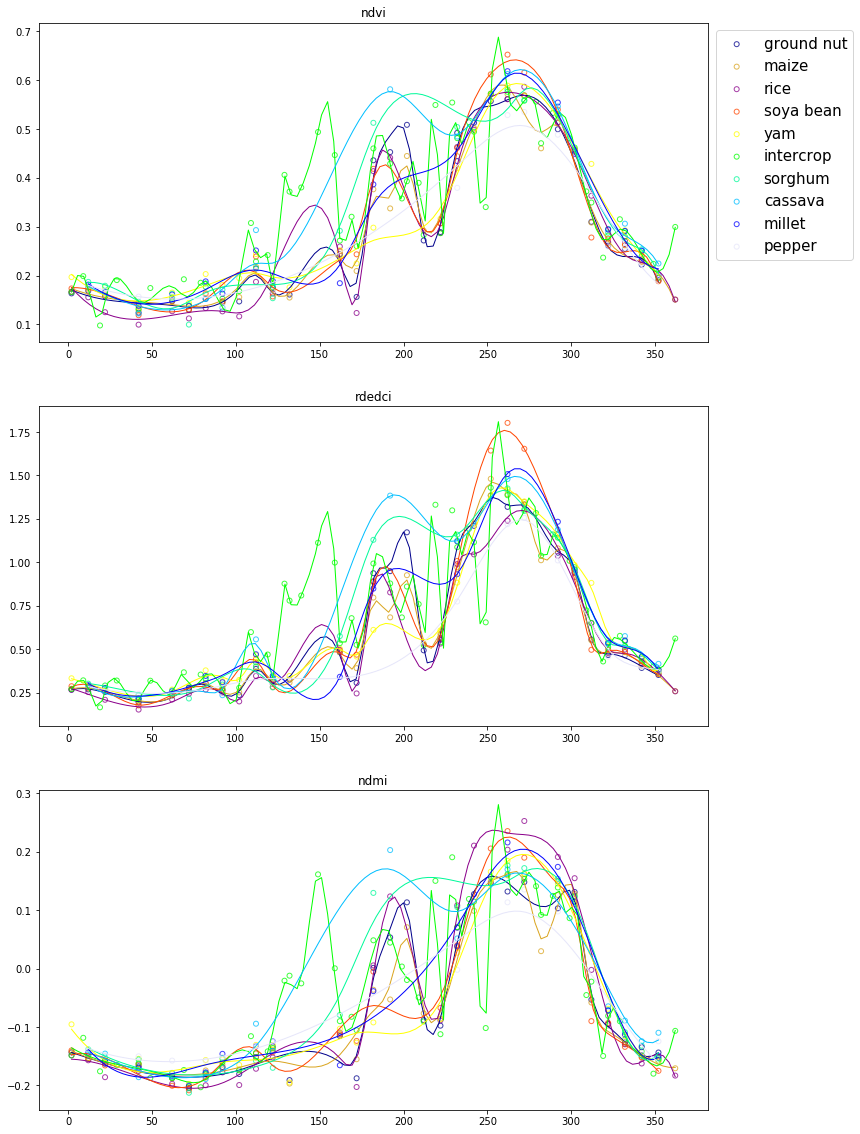

In [4]:
import matplotlib.pyplot
import scipy.interpolate

fix,ax = matplotlib.pyplot.subplots(3,1,figsize=[12,20])
axs = ax.ravel()
for i in range(len(vi)):
    for j in range(len(vi[0])):
        x = []
        y = []
        for k in range(len(vi[0][0])):
            if len(vi[i][j][k]) > 500:
                x.append(k)
                #y.append(numpy.median(vi[i][j][k]))
                y.append(numpy.percentile(vi[i][j][k],60))
        if len(x) > 15:
            spline = scipy.interpolate.UnivariateSpline(x,y,s=0.01,k=3)
            xnew = numpy.linspace(numpy.min(x),numpy.max(x),100)
            axs[j].scatter(x,y,edgecolors=groundlabels[i]["colour"],facecolors="None",s=25,alpha=0.75,label=groundlabels[i]["crop"])
            axs[j].plot(xnew,spline(xnew),color=groundlabels[i]["colour"],alpha=1,lw=1)
            axs[j].set_title(f"{s2indices[j]}")
axs[0].legend(bbox_to_anchor=(1.0,1.0),loc="upper left",fontsize=15)
matplotlib.pyplot.show()